In [533]:
# load package
import pandas as pd
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error #ÂùáÊñπËØØÂ∑Æ
from sklearn.metrics import mean_absolute_error #Âπ≥ÊñπÁªùÂØπËØØÂ∑Æ
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import scipy
import math
import geopandas as gp
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

In [619]:
# ËØÑ‰ª∑ÊåáÊ†á
def evaluation(real_y, prediction_y):

    # rmse  mae  r2  r
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(real_y, prediction_y)
    print("R-squared", r_value**2)
    print("R", r_value)

    mae = mean_absolute_error(real_y, prediction_y)
    print("mae", mae)

    rmse = mean_squared_error(real_y, prediction_y) ** 0.5
    print("rmse", rmse)

    ############# ËÆæÁΩÆÂõæ‰æãÂπ∂‰∏îËÆæÁΩÆÂõæ‰æãÁöÑÂ≠ó‰ΩìÂèäÂ§ßÂ∞è #############
    font1 = {'family': 'Times New Roman',
            'weight': 'normal',
            'size': 15,
            }
    
    figsize = 20,16
    figure, ax = plt.subplots(figsize=figsize)
    level = [50000, 5500, 1000, 200, 100, 80, 60, 40,20]
    for i in range(len(level)):

        plt.subplot(3,3,i+1)
        plt.scatter(real_y, prediction_y, c='b', marker='o', label='', s=10, alpha=0.7, zorder=20)
        plt.plot([0, 50000], [0, 50000], '--', color='black', label='', linewidth=1.0)
        
        ############# ËÆæÁΩÆÂùêÊ†áÂàªÂ∫¶ÂÄºÁöÑÂ§ßÂ∞è‰ª•ÂèäÂàªÂ∫¶ÂÄºÁöÑÂ≠ó‰Ωì #############
        plt.xlim(0, level[i])
        plt.ylim(0, level[i])
        plt.tick_params(labelsize=15)
        
        plt.ylabel('prediction', font1)
        plt.xlabel('real', font1)

        # xÔºåyËΩ¥ËÆæÁΩÆÊòæÁ§∫ÂàªÂ∫¶‰∏ÄËá¥
        ax = plt.gca()
        ax.set_aspect(1)
    
    plt.show()


# Áñ´ÊÉÖÂª∫Ê®°
def covid_all_predict(df, index, threshold):

    '''
    df = df[['id','location',
    'rhMean','rhMax','rhMin',
    't2mMean','t2mMax','t2mMin',
    'moveInMean','moveInMax','moveInMin',
    'moveOutMea','moveOutMax','moveOutMin',
    'travelMean','travelMax','travelMin',
    'WuhanMean','WuhanMax','WuhanMin',
    'confirmed','confirmLog','npp']]
    '''
    
    df = df[['id','location',
    'rhMean',
    't2mMean',
    'moveInMean',
    'moveOutMea',
    'travelMean',
    'WuhanMean',
    'confirmed','confirmLog', 'X', 'Y']]

    real_y = []
    prediction_y = []

    df_predict = []

    case = []

    for i in range(len(index)):

        train_df = df.iloc[index[i][0], :]
        test_df = df.iloc[index[i][1], :]

        df_predict.extend(test_df['id'].to_list())

        train_y_log = train_df['confirmLog'].values.reshape((-1,1))
        train_y = train_df['confirmed'].values.reshape((-1,1)).flatten()
        u = train_df['X']
        v = train_df['Y']
        cal_coords = list(zip(u,v))

        train_x = train_df.drop(['id', 'location', 'confirmLog', 'confirmed', 'X', 'Y'], axis=1).values

        test_y = test_df['confirmed'].values.reshape((-1,1)).flatten()
        test_x = test_df.drop(['id', 'location', 'confirmLog', 'confirmed', 'X', 'Y'], axis=1).values
        
        u = test_df['X']
        v = test_df['Y']
        pred_coords = list(zip(u,v))
        
        #Calibrate GWR model
        gwr_selector = Sel_BW(np.array(cal_coords), train_y_log, train_x)
        gwr_bw = gwr_selector.search(criterion = 'AICc')
        print(gwr_bw)
        model = GWR(np.array(cal_coords), train_y_log, train_x, gwr_bw)
        gwr_results = model.fit()

        scale = gwr_results.scale
        residuals = gwr_results.resid_response

        predict_ytrain_log = model.predict(np.array(cal_coords), train_x, scale, residuals).predictions.flatten()
        predict_ytrain = np.trunc(np.exp(predict_ytrain_log) - 1)

        predict_ytest_log = model.predict(np.array(pred_coords), test_x, scale, residuals).predictions.flatten()
        predict_ytest = np.trunc(np.exp(predict_ytest_log) - 1)
        
        
        real_y.extend(test_y)
        prediction_y.extend(predict_ytest)

        print("train fold " + str(i+1))
        print("È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫" + str(threshold))
        predict_train_y = list(predict_ytrain)
        train_yy = list(train_y)
        for j in range(len(train_df)):
            if abs(train_yy[j]-predict_train_y[j])>threshold:
                print(train_df.iloc[j, 1] + "   real: " + str(train_yy[j]) + "   pre:" + str(predict_train_y[j]))
                #case.append(train_df.iloc[j, 0])

        evaluation(train_yy, predict_train_y)


        print("#########################################")
        print("test fold " + str(i+1))
        print("È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫" + str(threshold))
        predict_test_y = list(predict_ytest)
        test_yy = list(test_y)
        for j in range(len(test_df)):
            if abs(test_yy[j]-predict_test_y[j])>threshold:
                print(test_df.iloc[j, 1] + "   real: " + str(test_yy[j]) + "   pre:" + str(predict_test_y[j]))
                case.append(test_df.iloc[j, 0])

        evaluation(test_yy, predict_test_y)
    

    df_predict = pd.DataFrame(df_predict)
    df_predict.columns = ['id']
    df_predict['predict'] = prediction_y

    print("************* cv evaluation ***************")
    evaluation(real_y, prediction_y)

    return case, df_predict

In [620]:
# ÊâÄÊúâÂüéÂ∏ÇÂÖ®Êó∂Èó¥ÊÆµÂª∫Ê®°

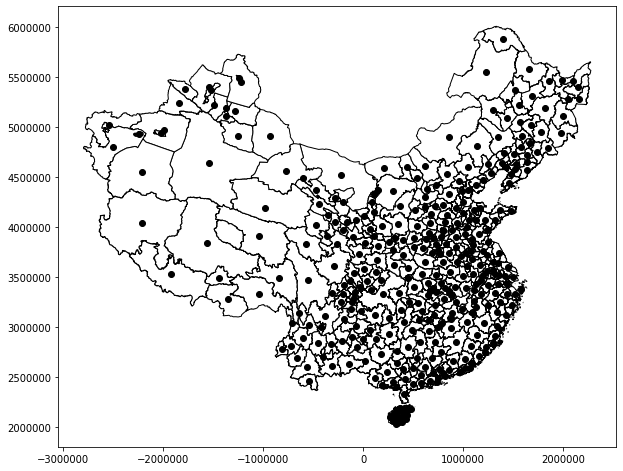

In [621]:
df = gp.GeoDataFrame.from_file("../shp/china_city_distinct_COVID19.shp")

fig, ax = plt.subplots(figsize=(10,10))
df.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})
df.centroid.plot(ax=ax, c='black')

66.0
train fold 1
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫50
Â§©Ê¥•Â∏Ç   real: 174   pre:74.0
ÂìàÂ∞îÊª®Â∏Ç   real: 198   pre:125.0
‰∏äÊµ∑Â∏Ç   real: 516   pre:627.0
ÂÆÅÊ≥¢Â∏Ç   real: 157   pre:71.0
ÈáëÂçéÂ∏Ç   real: 55   pre:119.0
Âè∞Â∑ûÂ∏Ç   real: 146   pre:57.0
‰∫≥Â∑ûÂ∏Ç   real: 108   pre:18.0
ÂçóÊòåÂ∏Ç   real: 230   pre:158.0
Êñ∞‰ΩôÂ∏Ç   real: 130   pre:76.0
ÊäöÂ∑ûÂ∏Ç   real: 72   pre:19.0
‰∏äÈ•∂Â∏Ç   real: 123   pre:42.0
ÊµéÂÆÅÂ∏Ç   real: 260   pre:43.0
ÈÉëÂ∑ûÂ∏Ç   real: 157   pre:300.0
ÂïÜ‰∏òÂ∏Ç   real: 91   pre:37.0
Ê≠¶Ê±âÂ∏Ç   real: 50006   pre:52283.0
ÈªÑÁü≥Â∏Ç   real: 1015   pre:602.0
ÂçÅÂ†∞Â∏Ç   real: 672   pre:381.0
Ë•ÑÈò≥Â∏Ç   real: 1175   pre:635.0
ÈÑÇÂ∑ûÂ∏Ç   real: 1394   pre:2053.0
ËçÜÈó®Â∏Ç   real: 928   pre:486.0
Âí∏ÂÆÅÂ∏Ç   real: 836   pre:477.0
ÈöèÂ∑ûÂ∏Ç   real: 1307   pre:591.0
ÊÅ©ÊñΩÂúüÂÆ∂ÊóèËãóÊóèËá™Ê≤ªÂ∑û   real: 252   pre:197.0
‰ªôÊ°ÉÂ∏Ç   real: 575   pre:896.0
Â§©Èó®Â∏Ç   real: 496   pre:287.0
ÈïøÊ≤ôÂ∏Ç   real: 242   pre:353.0
ÈÇµÈò≥Â∏Ç   real:

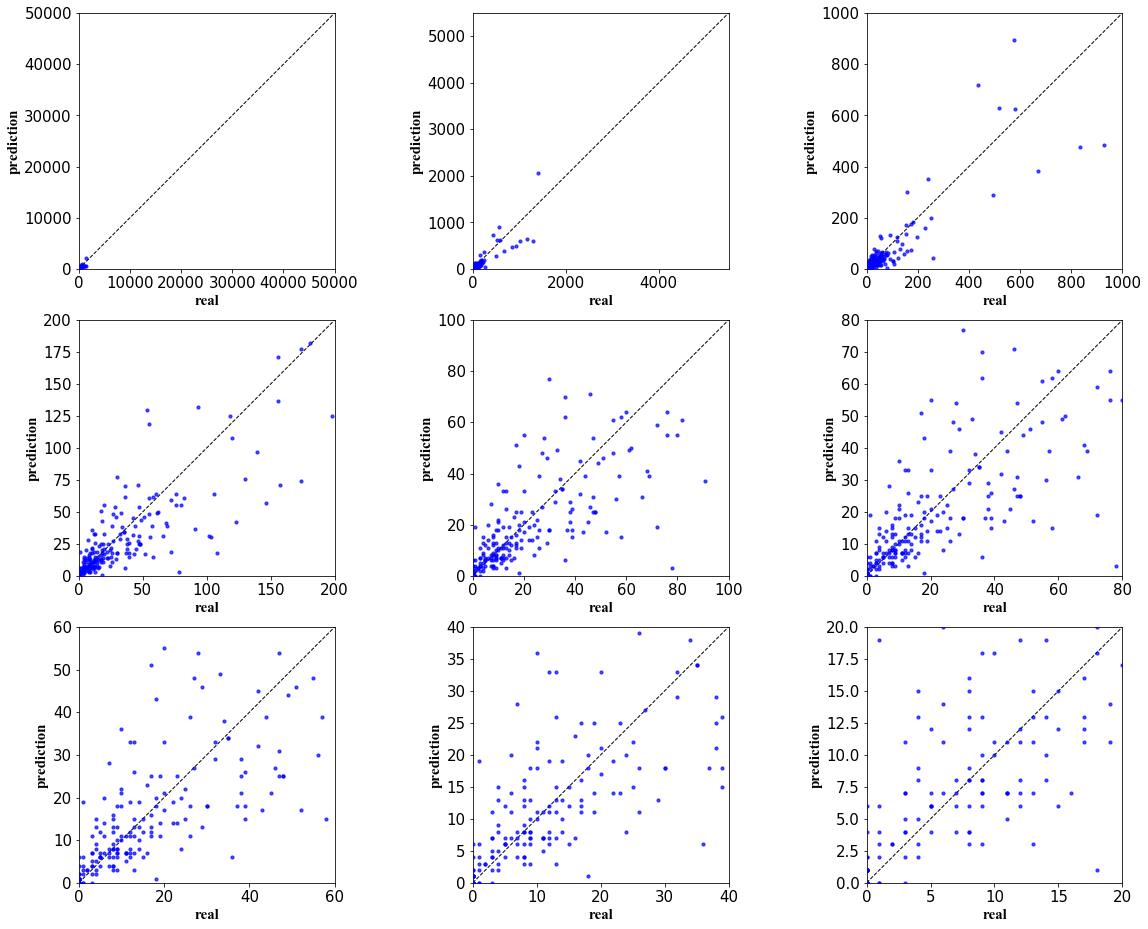

#########################################
test fold 1
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫50
Âåó‰∫¨Â∏Ç   real: 580   pre:1721.0
ËãèÂ∑ûÂ∏Ç   real: 87   pre:249.0
Ê∏©Â∑ûÂ∏Ç   real: 504   pre:183.0
ËöåÂü†Â∏Ç   real: 160   pre:50.0
ÂÆâÂ∫ÜÂ∏Ç   real: 83   pre:22.0
ÈòúÈò≥Â∏Ç   real: 155   pre:47.0
Ëµ£Â∑ûÂ∏Ç   real: 76   pre:21.0
ÂÆúÊòåÂ∏Ç   real: 931   pre:645.0
Â≠ùÊÑüÂ∏Ç   real: 3518   pre:5349.0
ËçÜÂ∑ûÂ∏Ç   real: 1580   pre:1347.0
ÈªÑÂÜàÂ∏Ç   real: 2907   pre:3858.0
ÊΩúÊ±üÂ∏Ç   real: 198   pre:635.0
Á•ûÂÜúÊû∂ÊûóÂå∫   real: 11   pre:149.0
Ê∑±Âú≥Â∏Ç   real: 450   pre:625.0
‰∏úËéûÂ∏Ç   real: 100   pre:265.0
ÊàêÈÉΩÂ∏Ç   real: 155   pre:1515.0
Ë¥µÈò≥Â∏Ç   real: 36   pre:150.0
Âí∏Èò≥Â∏Ç   real: 17   pre:90.0
Ê∏≠ÂçóÂ∏Ç   real: 15   pre:67.0
R-squared 0.9087928433068356
R 0.9533062694154674
mae 71.39669421487604
rmse 257.28228379295575


70.0
train fold 2
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫50
Ê∏©Â∑ûÂ∏Ç   real: 504   pre:194.0
Âè∞Â∑ûÂ∏Ç   real: 146   pre:47.0
‰∏ΩÊ∞¥Â∏Ç   real: 17   pre:68.0
ÂêàËÇ•Â∏Ç   real: 174   pre:273.0
ËöåÂü†Â∏Ç   real: 160   pre:51.0
ÂÆâÂ∫ÜÂ∏Ç   real: 83   pre:31.0
ÈòúÈò≥Â∏Ç   real: 155   pre:64.0
‰∫≥Â∑ûÂ∏Ç   real: 108   pre:21.0
ÂçóÊòåÂ∏Ç   real: 230   pre:162.0
‰∏äÈ•∂Â∏Ç   real: 123   pre:38.0
ÊµéÂÆÅÂ∏Ç   real: 260   pre:45.0
ÈÉëÂ∑ûÂ∏Ç   real: 157   pre:249.0
ÂçóÈò≥Â∏Ç   real: 156   pre:105.0
ÈªÑÁü≥Â∏Ç   real: 1015   pre:383.0
ÂÆúÊòåÂ∏Ç   real: 931   pre:244.0
ËçÜÈó®Â∏Ç   real: 928   pre:351.0
Â≠ùÊÑüÂ∏Ç   real: 3518   pre:2973.0
ËçÜÂ∑ûÂ∏Ç   real: 1580   pre:1025.0
ÈªÑÂÜàÂ∏Ç   real: 2907   pre:5530.0
ÈöèÂ∑ûÂ∏Ç   real: 1307   pre:372.0
ÊΩúÊ±üÂ∏Ç   real: 198   pre:397.0
ÈïøÊ≤ôÂ∏Ç   real: 242   pre:430.0
ÈÇµÈò≥Â∏Ç   real: 102   pre:28.0
Â≤≥Èò≥Â∏Ç   real: 156   pre:97.0
ÂπøÂ∑ûÂ∏Ç   real: 435   pre:648.0
Áè†Êµ∑Â∏Ç   real: 103   pre:27.0
‰∏úËéûÂ∏Ç   real: 100   pre:169.0
ÈáçÂ∫ÜÂ∏Ç

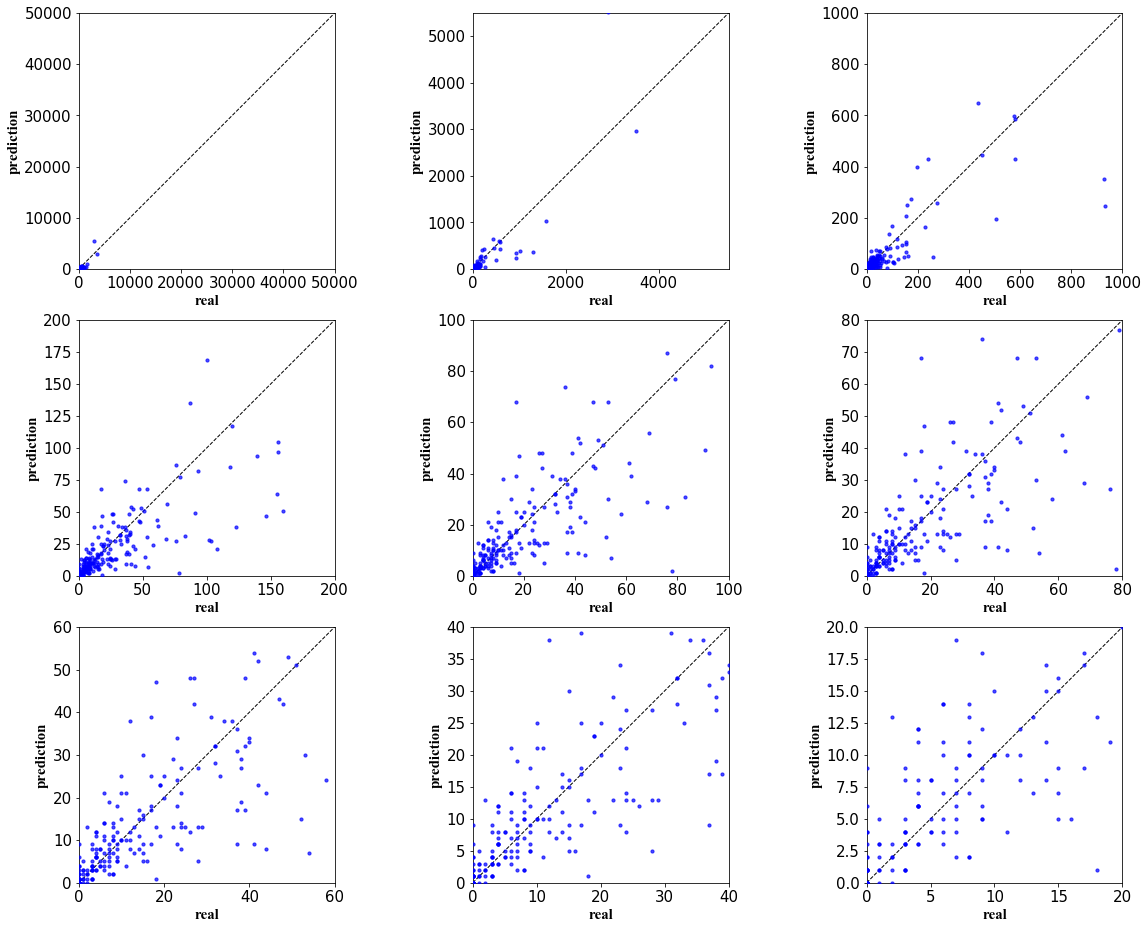

#########################################
test fold 2
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫50
Â§©Ê¥•Â∏Ç   real: 174   pre:76.0
ÂìàÂ∞îÊª®Â∏Ç   real: 198   pre:17.0
‰∏äÊµ∑Â∏Ç   real: 516   pre:253.0
Âçó‰∫¨Â∏Ç   real: 93   pre:249.0
Êù≠Â∑ûÂ∏Ç   real: 181   pre:411.0
ÂÆÅÊ≥¢Â∏Ç   real: 157   pre:44.0
ÊπñÂ∑ûÂ∏Ç   real: 10   pre:62.0
ÈáëÂçéÂ∏Ç   real: 55   pre:143.0
ÊªÅÂ∑ûÂ∏Ç   real: 13   pre:78.0
Êñ∞‰ΩôÂ∏Ç   real: 130   pre:41.0
ÂÆúÊò•Â∏Ç   real: 106   pre:47.0
ÊäöÂ∑ûÂ∏Ç   real: 72   pre:15.0
Ê≠¶Ê±âÂ∏Ç   real: 50006   pre:35288.0
ÂçÅÂ†∞Â∏Ç   real: 672   pre:153.0
Ë•ÑÈò≥Â∏Ç   real: 1175   pre:337.0
ÈÑÇÂ∑ûÂ∏Ç   real: 1394   pre:1224.0
Âí∏ÂÆÅÂ∏Ç   real: 836   pre:312.0
ÊÅ©ÊñΩÂúüÂÆ∂ÊóèËãóÊóèËá™Ê≤ªÂ∑û   real: 252   pre:121.0
Â§©Èó®Â∏Ç   real: 496   pre:229.0
R-squared 0.9994443387279514
R 0.999722130758318
mae 164.16666666666666
rmse 1348.5692418263143


64.0
train fold 3
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫50
Âåó‰∫¨Â∏Ç   real: 580   pre:776.0
Â§©Ê¥•Â∏Ç   real: 174   pre:70.0
‰∏äÊµ∑Â∏Ç   real: 516   pre:334.0
Âçó‰∫¨Â∏Ç   real: 93   pre:220.0
ËãèÂ∑ûÂ∏Ç   real: 87   pre:142.0
Êù≠Â∑ûÂ∏Ç   real: 181   pre:304.0
ÂÆÅÊ≥¢Â∏Ç   real: 157   pre:53.0
Ê∏©Â∑ûÂ∏Ç   real: 504   pre:210.0
ÈáëÂçéÂ∏Ç   real: 55   pre:139.0
ËöåÂü†Â∏Ç   real: 160   pre:45.0
ÂÆâÂ∫ÜÂ∏Ç   real: 83   pre:31.0
ÈòúÈò≥Â∏Ç   real: 155   pre:46.0
ÂçóÂπ≥Â∏Ç   real: 20   pre:73.0
Êñ∞‰ΩôÂ∏Ç   real: 130   pre:55.0
ÊäöÂ∑ûÂ∏Ç   real: 72   pre:20.0
Ê≠¶Ê±âÂ∏Ç   real: 50006   pre:49893.0
ÂçÅÂ†∞Â∏Ç   real: 672   pre:172.0
ÂÆúÊòåÂ∏Ç   real: 931   pre:340.0
Ë•ÑÈò≥Â∏Ç   real: 1175   pre:423.0
ÈÑÇÂ∑ûÂ∏Ç   real: 1394   pre:1330.0
Â≠ùÊÑüÂ∏Ç   real: 3518   pre:3320.0
ËçÜÂ∑ûÂ∏Ç   real: 1580   pre:1187.0
ÈªÑÂÜàÂ∏Ç   real: 2907   pre:5092.0
Âí∏ÂÆÅÂ∏Ç   real: 836   pre:304.0
ÊÅ©ÊñΩÂúüÂÆ∂ÊóèËãóÊóèËá™Ê≤ªÂ∑û   real: 252   pre:129.0
ÊΩúÊ±üÂ∏Ç   real: 198   pre:358.0
Â§©Èó®Â∏Ç   real: 

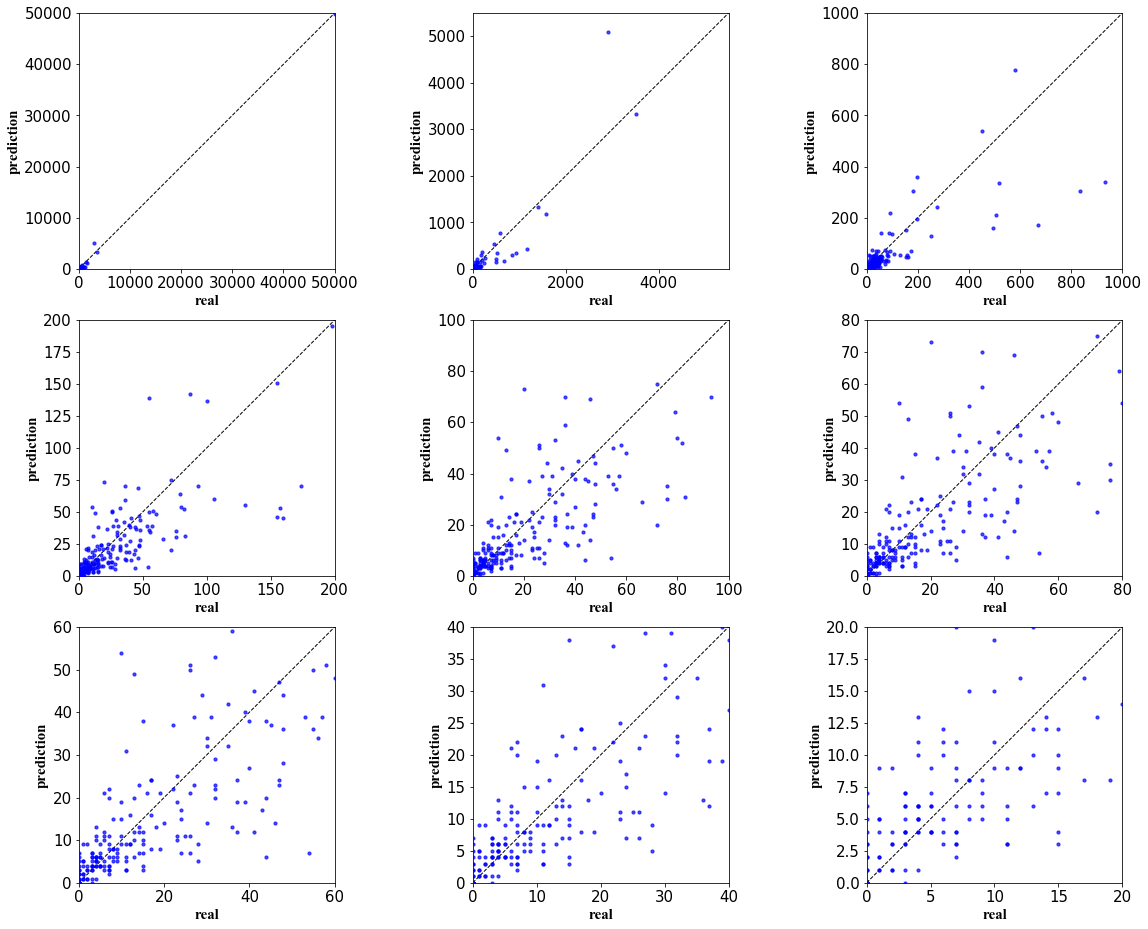

#########################################
test fold 3
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫50
Ê≤àÈò≥Â∏Ç   real: 28   pre:203.0
Âè∞Â∑ûÂ∏Ç   real: 146   pre:55.0
‰∏ΩÊ∞¥Â∏Ç   real: 17   pre:70.0
ÂêàËÇ•Â∏Ç   real: 174   pre:311.0
‰∫≥Â∑ûÂ∏Ç   real: 108   pre:10.0
ÂçóÊòåÂ∏Ç   real: 230   pre:175.0
‰∏äÈ•∂Â∏Ç   real: 123   pre:41.0
ÊµéÂÆÅÂ∏Ç   real: 260   pre:45.0
ÈÉëÂ∑ûÂ∏Ç   real: 157   pre:1792.0
ÂïÜ‰∏òÂ∏Ç   real: 91   pre:36.0
ÈªÑÁü≥Â∏Ç   real: 1015   pre:417.0
ËçÜÈó®Â∏Ç   real: 928   pre:318.0
ÈöèÂ∑ûÂ∏Ç   real: 1307   pre:396.0
ÈïøÊ≤ôÂ∏Ç   real: 242   pre:1068.0
ÈÇµÈò≥Â∏Ç   real: 102   pre:27.0
ÂπøÂ∑ûÂ∏Ç   real: 435   pre:605.0
Áè†Êµ∑Â∏Ç   real: 103   pre:16.0
ÈáçÂ∫ÜÂ∏Ç   real: 579   pre:1159.0
ÁîòÂ≠úËóèÊóèËá™Ê≤ªÂ∑û   real: 78   pre:0.0
ÊòÜÊòéÂ∏Ç   real: 53   pre:151.0
Ë•øÂÆâÂ∏Ç   real: 120   pre:30.0
R-squared 0.2442318756169174
R 0.49419821490664795
mae 63.625
rmse 213.44626568139657


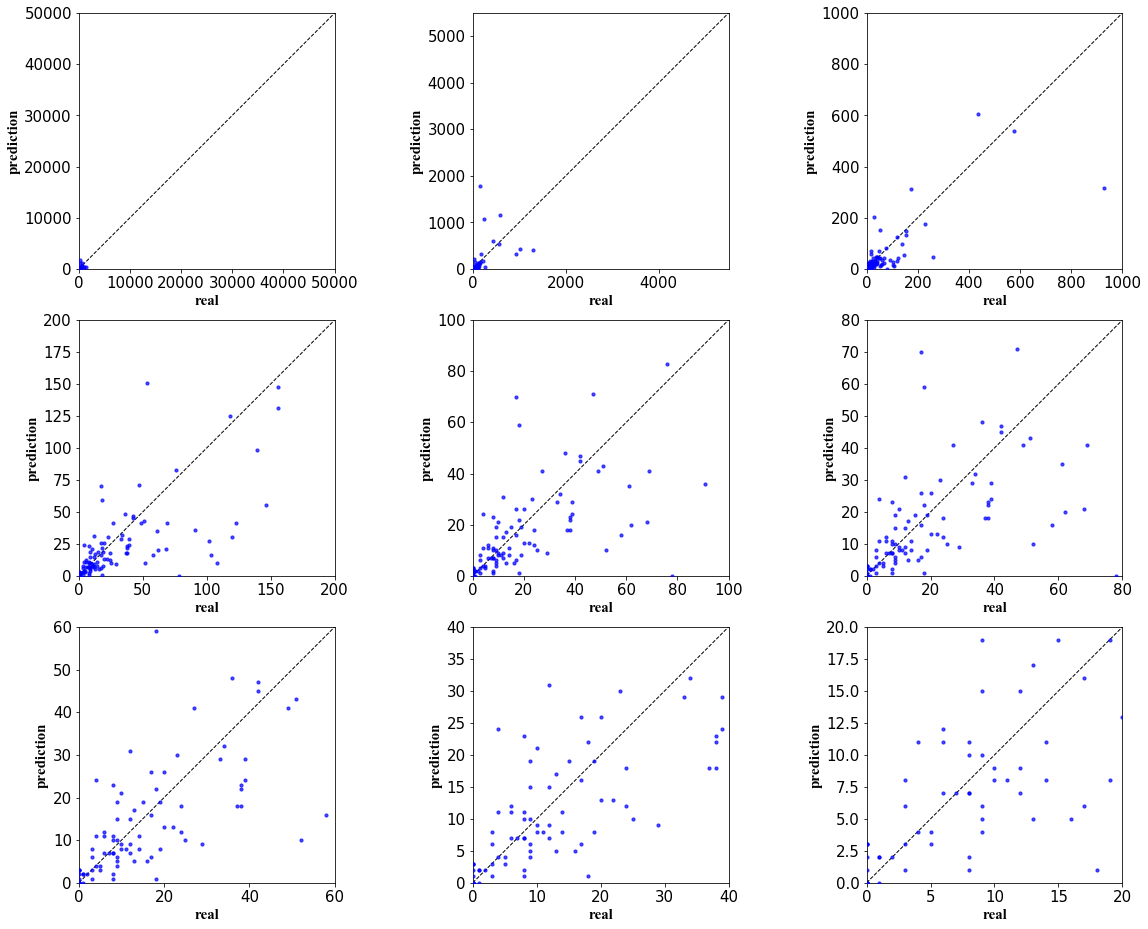

************* cv evaluation ***************
R-squared 0.9838402943553309
R 0.9918872387299531
mae 99.65096952908587
rmse 801.1648237361921


In [622]:
kf = KFold(3, True)
index = []
for train_index, test_index in kf.split(df):
    index.append((train_index, test_index))

# epidemic id Áñ´ÊÉÖÁÅæÂå∫idÔºåÊöÇÂÆöÊ≠¶Ê±â
epidemicIds = [420100]

# ÂÖ®Êó∂Èó¥ÊÆµÂª∫Ê®°
#df = df[~df['id'].isin(epidemicIds)]
case, df_predict = covid_all_predict(df, index, threshold = 50)

In [623]:
df = pd.merge(df, df_predict, how='inner', on='id')
df['diff'] = df['confirmed'] - df['predict']
df = df[df['id'].isin(case)]
df = df[['id','location','confirmed', 'predict',
    'rhMean',
    't2mMean',
    'moveInMean',
    'moveOutMea',
    'travelMean',
    'WuhanMean',
     'diff']]

In [624]:
# È¢ÑÊµãËøá‰ΩéÁöÑÂüéÂ∏Ç

# ‰∏éÈöèÊú∫Ê£ÆÊûóÈ¢ÑÊµãËøá‰ΩéÁöÑÁªìÊûúÁ±ª‰ººÔºå‰∏çËøáÊàë‰∏çÁü•ÈÅìÊÄé‰πàËß£ÈáäÔºåÂÆûÂú®‰∏çÊáÇËøô‰∏™Ê®°Âûã„ÄÇ„ÄÇ„ÄÇ

In [625]:
df[df['diff']>0].sort_values(by='diff', ascending=False)

id    location  confirmed  predict     rhMean     t2mMean  \
167  420100         Ê≠¶Ê±âÂ∏Ç      50006  35288.0  71.607512  282.498292   
178  421300         ÈöèÂ∑ûÂ∏Ç       1307    396.0  70.903198  281.069625   
171  420600         Ë•ÑÈò≥Â∏Ç       1175    337.0  71.201756  280.692857   
173  420800         ËçÜÈó®Â∏Ç        928    318.0  71.598185  281.899670   
168  420200         ÈªÑÁü≥Â∏Ç       1015    417.0  75.269348  282.796069   
177  421200         Âí∏ÂÆÅÂ∏Ç        836    312.0  76.139420  282.601893   
169  420300         ÂçÅÂ†∞Â∏Ç        672    153.0  71.845056  279.256399   
88   330300         Ê∏©Â∑ûÂ∏Ç        504    183.0  78.798802  284.332806   
170  420500         ÂÆúÊòåÂ∏Ç        931    645.0  76.941379  280.064152   
182  429006         Â§©Èó®Â∏Ç        496    229.0  70.732168  282.236873   
72   310000         ‰∏äÊµ∑Â∏Ç        516    253.0  73.452783  282.566128   
175  421000         ËçÜÂ∑ûÂ∏Ç       1580   1347.0  72.381365  282.634814   
140  370800         ÊµéÂÆÅÂ∏Ç        260     45.0  58.888329  279.340166   
59   230100        ÂìàÂ∞îÊª®Â∏Ç        198     17.0  57.265352  263.730509   
172  420700         ÈÑÇÂ∑ûÂ∏Ç       1394   1224.0  73.026692  283.062423   
179  422800  ÊÅ©ÊñΩÂúüÂÆ∂ÊóèËãóÊóèËá™Ê≤ªÂ∑û        252    121.0  81.020041  279.809750   
87   330200         ÂÆÅÊ≥¢Â∏Ç        157     44.0  76.368995  283.428903   
99   340300         ËöåÂü†Â∏Ç        160     50.0  66.674392  280.875821   
107  341200         ÈòúÈò≥Â∏Ç        155     47.0  66.230821  280.972478   
110  341600         ‰∫≥Â∑ûÂ∏Ç        108     10.0  64.801841  280.681770   
1    120000         Â§©Ê¥•Â∏Ç        174     76.0  46.564947  276.009576   
95   331000         Âè∞Â∑ûÂ∏Ç        146     55.0  76.528690  283.901061   
305  610100         Ë•øÂÆâÂ∏Ç        120     30.0  63.974433  278.483058   
126  360500         Êñ∞‰ΩôÂ∏Ç        130     41.0  78.131302  284.211092   
201  440400         Áè†Êµ∑Â∏Ç        103     16.0  79.781177  291.894214   
132  361100         ‰∏äÈ•∂Â∏Ç        123     41.0  76.747276  284.403663   
271  513300     ÁîòÂ≠úËóèÊóèËá™Ê≤ªÂ∑û         78      0.0  74.243101  262.575154   
188  430500         ÈÇµÈò≥Â∏Ç        102     27.0  82.883360  282.701955   
104  340800         ÂÆâÂ∫ÜÂ∏Ç         83     22.0  75.882997  281.324144   
130  360900         ÂÆúÊò•Â∏Ç        106     47.0  78.277217  283.468613   
131  361000         ÊäöÂ∑ûÂ∏Ç         72     15.0  79.995741  284.998420   
128  360700         Ëµ£Â∑ûÂ∏Ç         76     21.0  80.078094  286.214047   
122  360100         ÂçóÊòåÂ∏Ç        230    175.0  75.982319  284.077013   
162  411400         ÂïÜ‰∏òÂ∏Ç         91     36.0  61.217168  280.406173   

     moveInMean  moveOutMea  travelMean   WuhanMean     diff  
167    1.441894    2.023355    1.722975  100.000000  14718.0  
178    0.238099    0.192810    2.924918    2.167692    911.0  
171    0.499872    0.428895    3.136352    3.597582    838.0  
173    0.321647    0.279806    3.208329    2.742308    610.0  
168    0.349638    0.311960    3.025581    3.193187    598.0  
177    0.329820    0.267432    3.433240    6.370220    524.0  
169    0.275357    0.244492    3.025281    3.124835    519.0  
88     1.139140    1.407472    3.042697    0.088022    321.0  
170    0.421915    0.356423    3.151497    4.472088    286.0  
182    0.215931    0.166151    3.510089    1.978901    267.0  
72     4.328343    4.793034    3.975281    0.468352    263.0  
175    0.692491    0.586977    3.262016    6.604396    233.0  
140    1.037987    1.054186    3.997379    0.017033    215.0  
59     1.204409    1.125335    3.094146    0.075495    181.0  
172    0.230197    0.226363    2.240659    4.990220    170.0  
179    0.415623    0.325181    3.908862    4.745824    131.0  
87     1.555052    1.786547    4.115321    0.073956    113.0  
99     0.632193    0.616336    4.030465    0.003077    110.0  
107    1.303301    1.237327    4.651288    0.193956    108.0  
110    0.923538    0.901964    5.110129    0.016484     98.0  
1      

In [626]:
# È¢ÑÊµãËøáÈ´òÁöÑÂüéÂ∏Ç
# ÈÉëÂ∑ûÂíåÊàêÈÉΩÈ´òÁöÑÊúâ‰∫õÁ¶ªË∞±

In [627]:
df[df['diff']<0].sort_values(by='diff', ascending=True)

id location  confirmed  predict     rhMean     t2mMean  moveInMean  \
174  420900      Â≠ùÊÑüÂ∏Ç       3518   5349.0  71.152424  281.712290    0.581259   
149  410100      ÈÉëÂ∑ûÂ∏Ç        157   1792.0  58.902450  280.062032    3.181735   
252  510100      ÊàêÈÉΩÂ∏Ç        155   1515.0  75.993469  280.945180    4.778249   
0    110000      Âåó‰∫¨Â∏Ç        580   1721.0  46.602664  272.940185    4.460553   
176  421100      ÈªÑÂÜàÂ∏Ç       2907   3858.0  73.669439  281.858747    0.785669   
184  430100      ÈïøÊ≤ôÂ∏Ç        242   1068.0  78.196887  283.294240    3.008522   
251  500000      ÈáçÂ∫ÜÂ∏Ç        579   1159.0  77.692175  282.481705    3.243957   
181  429005      ÊΩúÊ±üÂ∏Ç        198    635.0  71.633491  282.448468    0.142624   
86   330100      Êù≠Â∑ûÂ∏Ç        181    411.0  77.657035  282.227114    3.197163   
36   210100      Ê≤àÈò≥Â∏Ç         28    203.0  46.205393  269.799160    1.761477   
200  440300      Ê∑±Âú≥Â∏Ç        450    625.0  75.376723  291.932983    5.067225   
198  440100      ÂπøÂ∑ûÂ∏Ç        435    605.0  74.345041  290.998782    5.852615   
214  441900      ‰∏úËéûÂ∏Ç        100    265.0  73.029139  292.042149    4.323698   
77   320500      ËãèÂ∑ûÂ∏Ç         87    249.0  72.714776  282.295452    3.541147   
73   320100      Âçó‰∫¨Â∏Ç         93    249.0  71.242635  281.685157    2.398367   
183  429021    Á•ûÂÜúÊû∂ÊûóÂå∫         11    149.0  77.393266  276.827200    0.016378   
97   340100      ÂêàËÇ•Â∏Ç        174    311.0  70.687448  281.625081    2.116167   
273  520100      Ë¥µÈò≥Â∏Ç         36    150.0  83.624122  282.344338    1.999593   
282  530100      ÊòÜÊòéÂ∏Ç         53    151.0  56.374357  285.399073    2.400087   
92   330700      ÈáëÂçéÂ∏Ç         55    143.0  76.514689  283.595942    1.343966   
308  610400      Âí∏Èò≥Â∏Ç         17     90.0  56.298656  277.463500    1.486048   
106  341100      ÊªÅÂ∑ûÂ∏Ç         13     78.0  69.350020  281.095948    0.932446   
96   331100      ‰∏ΩÊ∞¥Â∏Ç         17     70.0  79.044299  283.778965    0.340126   
90   330500      ÊπñÂ∑ûÂ∏Ç         10     62.0  75.783847  282.179100    0.867750   
309  610500      Ê∏≠ÂçóÂ∏Ç         15     67.0  54.562555  278.469474    0.837042   

     moveOutMea  travelMean  WuhanMean    diff  
174    0.472132    2.987432  15.480989 -1831.0  
149    3.165202    3.335111   0.483516 -1635.0  
252    5.096423    3.602126   0.277692 -1360.0  
0      4.917454    3.281025   0.467143 -1141.0  
176    0.582993    3.386525  18.594066  -951.0  
184    3.068457    3.394593   0.728791  -826.0  
251    3.053466    3.642029   0.571319  -580.0  
181    0.125334    2.839349   1.044615  -437.0  
86     3.296147    3.844199   0.184286  -230.0  
36     1.701233    4.103195   0.062967  -175.0  
200    5.783426    2.831347   0.468242  -175.0  
198    6.362721    2.795382   0.400220  -170.0  
214    4.746953    2.528005   0.186484  -165.0  
77     3.844228    4.246995   0.177363  -162.0  
73     2.406306    3.877563   0.238901  -156.0  
183    0.015461    3.155568   0.064176  -138.0  
97     2.124394    3.678656   0.321099  -137.0  
273    1.923813    3.421212   0.098132  -114.0  
282    2.355344    3.478513   0.145385   -98.0  
92     1.463180    3.452486   0.067363   -88.0  
308    1.364976    3.261233   0.012967   -73.0  
106    0.798812    4.458327   0.008132   -65.0  
96     0.316919    3.654426   0.000440   -53.0  
90     0.852515    4.053534   0.048022   -52.0  
309    0.800130    3.489967   0.000000   -52.0

In [ ]:
# GWRËÆ≠ÁªÉÂæà‰∏çÁ®≥ÂÆöÔºåcv-R2ÂÄíÊòØÂæàÈ´òÔºå‰∏ÄÁõ¥ÂæàÈ´òÔºåÈÉΩÊòØ0.9‰ª•‰∏ä

# cvÈ¢ÑÊµãÁªìÊûúÈùûÂ∏∏‰∏çÁ®≥ÂÆöÔºåÊ≠¶Ê±âÊúâÁöÑÊó∂ÂÄôÈ¢ÑÊµãÈ´òÁöÑËææÂà∞e10Â∑¶Âè≥ÔºåÂÖ∂‰ªñÂú∞Âå∫ÔºàÊπñÂåóÁ≠âÂú∞ÔºâÈÉΩ‰∏ä‰∏á

# ÊàëË∞É‰∫ÜÂæà‰πÖÔºåÊåë‰∫Ü‰∏™ËøòÁÆó‰∏çÈÇ£‰πàÁ¶ªË∞±ÁöÑÁªìÊûúÔºå‰∏çËøá‰πüÂ≠òÂú®ÂæàÂ§ö‰∏çÂêàÁêÜÁöÑÂú∞ÊñπÔºåÈ¢ÑÊµãËøá‰ΩéÁöÑÂú∞ÊñπÂæàÂ§öË∑üÊ≠¶Ê±âÈÉΩÊ≤°ÊúâÁõ¥Êé•ËÅîÁ≥ªÔºå

In [261]:
# ÁÆ°ÊéßÂâçÂêÑ‰∏™ÂüéÂ∏ÇÁñ´ÊÉÖÈ¢ÑÊµã
df = gp.GeoDataFrame.from_file("../shp/china_city_distinct_COVID19_before.shp")  
kf = KFold(3, True)
index = []
for train_index, test_index in kf.split(df):
    index.append((train_index, test_index))

# epidemic id Áñ´ÊÉÖÁÅæÂå∫idÔºåÊöÇÂÆöÊ≠¶Ê±â
epidemicIds = [420100]

# ÂÖ®Êó∂Èó¥ÊÆµÂª∫Ê®°
#df = df[~df['id'].isin(epidemicIds)]
case, df_predict = covid_all_predict(df, index, threshold = 20)

In [131]:
df = pd.merge(df, df_predict, how='inner', on='id')
df['diff'] = df['confirmed'] - df['predict']
df = df[df['id'].isin(case)]
df = df[['id','location','confirmed', 'predict',
    'rhMean',
    't2mMean',
    'moveInMean',
    'moveOutMea',
    'travelMean',
    'WuhanMean',
     'diff']]

In [132]:
df[df['diff']>0].sort_values(by='diff', ascending=False)

id location  confirmed  predict     rhMean     t2mMean  moveInMean  \
167  420100      Ê≠¶Ê±âÂ∏Ç        698     46.0  82.161216  277.927893    3.691429   
176  421100      ÈªÑÂÜàÂ∏Ç        154     46.0  82.857096  277.756878    2.274531   
251  500000      ÈáçÂ∫ÜÂ∏Ç        110     23.0  81.690700  279.615017    6.699337   
173  420800      ËçÜÈó®Â∏Ç         90     26.0  79.101923  277.325860    0.786025   
0    110000      Âåó‰∫¨Â∏Ç         68     25.0  46.952353  267.598395    8.432141   
177  421200      Âí∏ÂÆÅÂ∏Ç         64     25.0  86.336734  278.122550    0.928249   
178  421300      ÈöèÂ∑ûÂ∏Ç         52     19.0  79.398717  276.382933    0.649905   
72   310000      ‰∏äÊµ∑Â∏Ç         53     24.0  80.613952  280.957940    6.154784   
88   330300      Ê∏©Â∑ûÂ∏Ç         32      7.0  81.075343  283.464677    1.632216   

     moveOutMea  travelMean   WuhanMean   diff  
167    6.322494    4.120335  100.000000  652.0  
176    1.006516    4.852458   12.606538  108.0  
251    5.046055    5.064838    1.210385   87.0  
173    0.501414    5.055546    3.047308   64.0  
0     13.719755    5.149477    1.179615   43.0  
177    0.532652    5.350531    5.103462   39.0  
178    0.343983    4.675454    2.953077   33.0  
72    12.054880    5.327500    0.891154   29.0  
88     3.456391    4.197485    0.201538   25.0

In [133]:
df[df['diff']<0].sort_values(by='diff', ascending=True)

id location  confirmed  predict     rhMean     t2mMean  moveInMean  \
174  420900      Â≠ùÊÑüÂ∏Ç        100    141.0  80.659195  277.136510    1.596307   
180  429004      ‰ªôÊ°ÉÂ∏Ç         12     41.0  81.704573  277.975140    0.526281   
198  440100      ÂπøÂ∑ûÂ∏Ç         39     67.0  71.248583  290.618403    7.572659   
172  420700      ÈÑÇÂ∑ûÂ∏Ç         20     47.0  83.553880  278.572922    0.605509   
181  429005      ÊΩúÊ±üÂ∏Ç          5     30.0  79.753080  277.999688    0.332992   
184  430100      ÈïøÊ≤ôÂ∏Ç         22     43.0  85.910260  279.149545    4.208644   

     moveOutMea  travelMean  WuhanMean  diff  
174    0.961099    4.722062  13.395769 -41.0  
180    0.306374    4.384712   2.761154 -29.0  
198   14.140525    3.804012   0.671154 -28.0  
172    0.549913    4.082238   4.457692 -27.0  
181    0.221503    4.443785   1.108462 -25.0  
184    6.180231    4.447612   1.194231 -21.0

In [ ]:
# ÁÆ°ÊéßÂâçÈ¢ÑÊµãËøáÈ´òÂíåËøá‰ΩéÁöÑÊÉÖÂÜµ‰∏éÂÖ®Êó∂Èó¥ÊÆµÂü∫Êú¨Á±ª‰ºº
df = gp.GeoDataFrame.from_file("../shp/china_city_distinct_COVID19_after.shp")
    
kf = KFold(3, True)
index = []
for train_index, test_index in kf.split(df):
    index.append((train_index, test_index))

# ÂÖ®Êó∂Èó¥ÊÆµÂª∫Ê®°
#df = df[~df['id'].isin(epidemicIds)]
case, df_predict = covid_all_predict(df, index, threshold=50)

In [138]:
df = pd.merge(df, df_predict, how='inner', on='id')
df['diff'] = df['confirmed'] - df['predict']
df = df[df['id'].isin(case)]
df = df[['id','location','confirmed', 'predict',
    'rhMean',
    't2mMean',
    'moveInMean',
    'moveOutMea',
    'travelMean',
    'WuhanMean',
     'diff']]

In [ ]:
# ÁÆ°ÊéßÂêéÈ¢ÑÊµãËøáÈ´òÂíåËøá‰ΩéÁöÑÊÉÖÂÜµ‰∏éÂÖ®Êó∂Èó¥ÊÆµÂü∫Êú¨Á±ª‰ºº

In [139]:
df[df['diff']>0].sort_values(by='diff', ascending=False)

id location  confirmed  predict     rhMean     t2mMean  moveInMean  \
167  420100      Ê≠¶Ê±âÂ∏Ç      49308    597.0  67.548395  284.256138    0.542080   
174  420900      Â≠ùÊÑüÂ∏Ç       3418    880.0  67.495974  283.472206    0.175240   
176  421100      ÈªÑÂÜàÂ∏Ç       2753   1391.0  70.135725  283.436388    0.190124   
178  421300      ÈöèÂ∑ûÂ∏Ç       1255    462.0  67.635691  282.872199    0.073377   
175  421000      ËçÜÂ∑ûÂ∏Ç       1533    803.0  69.231072  284.337159    0.237780   
172  420700      ÈÑÇÂ∑ûÂ∏Ç       1374    725.0  68.977774  284.789154    0.080072   
88   330300      Ê∏©Â∑ûÂ∏Ç        472     30.0  77.923209  284.666702    0.941910   
0    110000      Âåó‰∫¨Â∏Ç        512     89.0  46.468169  274.994719    2.871917   
171  420600      Ë•ÑÈò≥Â∏Ç       1139    745.0  67.982955  282.419131    0.180650   
72   310000      ‰∏äÊµ∑Â∏Ç        463    154.0  70.698488  283.184662    3.597767   
251  500000      ÈáçÂ∫ÜÂ∏Ç        469    221.0  76.154281  283.584278    1.861806   
198  440100      ÂπøÂ∑ûÂ∏Ç        396    162.0  75.535987  291.145081    5.164597   
140  370800      ÊµéÂÆÅÂ∏Ç        255     41.0  56.263377  281.139767    0.655156   
59   230100     ÂìàÂ∞îÊª®Â∏Ç        190     31.0  52.731429  266.200924    0.707684   
170  420500      ÂÆúÊòåÂ∏Ç        900    745.0  74.232422  281.635819    0.186240   
99   340300      ËöåÂü†Â∏Ç        157      5.0  62.243918  282.380396    0.356936   
126  360500      Êñ∞‰ΩôÂ∏Ç        127      2.0  76.377866  285.450101    0.098953   
95   331000      Âè∞Â∑ûÂ∏Ç        124     11.0  74.510593  284.455340    0.685784   
163  411500      ‰ø°Èò≥Â∏Ç        251    153.0  65.156832  282.878631    0.330938   
1    120000      Â§©Ê¥•Â∏Ç        160     66.0  46.642699  277.967881    1.476379   
110  341600      ‰∫≥Â∑ûÂ∏Ç        102      9.0  60.748466  282.289942    0.485567   
87   330200      ÂÆÅÊ≥¢Â∏Ç        144     52.0  73.790800  283.983610    1.495799   
86   330100      Êù≠Â∑ûÂ∏Ç        154     64.0  74.497189  283.243679    2.749666   
132  361100      ‰∏äÈ•∂Â∏Ç        117     31.0  74.089452  285.501922    0.405214   
122  360100      ÂçóÊòåÂ∏Ç        222    137.0  73.035140  285.366712    0.798778   
107  341200      ÈòúÈò≥Â∏Ç        145     64.0  61.743429  282.633131    0.634403   
168  420200      ÈªÑÁü≥Â∏Ç        979    898.0  71.633199  284.422040    0.121287   
165  411700     È©ªÈ©¨Â∫óÂ∏Ç        130     49.0  62.218938  282.680697    0.455279   
201  440400      Áè†Êµ∑Â∏Ç         91     11.0  80.093177  292.072803    0.949299   
188  430500      ÈÇµÈò≥Â∏Ç         94     18.0  80.983450  284.155163    0.482991   
271  513300  ÁîòÂ≠úËóèÊóèËá™Ê≤ªÂ∑û         76      0.0  72.909072  263.841379    0.100721   
130  360900      ÂÆúÊò•Â∏Ç        100     38.0  75.889526  284.762245    0.388863   
131  361000      ÊäöÂ∑ûÂ∏Ç         65     10.0  78.343477  286.123932    0.249466   
196  431300      Â®ÑÂ∫ïÂ∏Ç         69     16.0  78.550672  283.944862    0.381381   
115  350300      ËéÜÁî∞Â∏Ç         55      3.0  78.624973  286.982403    0.261779   
63   230500     ÂèåÈ∏≠Â±±Â∏Ç         51      0.0  53.550778  266.646158    0.060108   

     moveOutMea  travelMean   WuhanMean     diff  
167    0.303700    0.764031  100.000000  48711.0  
174    0.276545    2.293580   16.315077   2538.0  
176    0.413585    2.800152   20.989077   1362.0  
178    0.132341    2.224703    1.853538    793.0  
175    0.419148    2.643878    6.812923    730.0  
172    0.096943    1.504028    5.203231    649.0  
88     0.587904    2.580782    0.042615    442.0  
0      1.396534    2.533645    0.182154    423.0  
171    0.282184    2.327737    3.511538    394.0  
72     1.888296    3.434394    0.299231    309.0  
251    2.256431    3.072905    0.315692    248.0  
198    3.251599    2.391931    0.291846    234.0  
140    0.872109    3.435500    0.010769    214.0  
59     0.582269    2.298325    0.042154    159.0  
170    0.215876    2.396275    5.157385    155.0  
99     0.523175    3.398728    0.004308

In [140]:
df[df['diff']<0].sort_values(by='diff', ascending=True)

id    location  confirmed  predict     rhMean     t2mMean  \
179  422800  ÊÅ©ÊñΩÂúüÂÆ∂ÊóèËãóÊóèËá™Ê≤ªÂ∑û        227    825.0  78.710185  281.009652   
181  429005         ÊΩúÊ±üÂ∏Ç        193    728.0  68.510573  284.159537   
182  429006         Â§©Èó®Â∏Ç        483    905.0  67.397417  283.935709   
180  429004         ‰ªôÊ°ÉÂ∏Ç        563    969.0  68.048552  284.140160   
149  410100         ÈÉëÂ∑ûÂ∏Ç        128    367.0  54.497972  282.009780   
184  430100         ÈïøÊ≤ôÂ∏Ç        220    422.0  75.230205  284.888353   
161  411300         ÂçóÈò≥Â∏Ç        137    285.0  62.697251  281.920763   
185  430200         Ê†™Ê¥≤Â∏Ç         75    210.0  77.636058  285.841944   
214  441900         ‰∏úËéûÂ∏Ç         98    215.0  73.799657  292.110542   
125  360400         ‰πùÊ±üÂ∏Ç        114    191.0  75.150334  284.121798   
73   320100         Âçó‰∫¨Â∏Ç         86    162.0  66.526100  282.940633   

     moveInMean  moveOutMea  travelMean  WuhanMean   diff  
179    0.157376    0.257877    3.280932   5.884308 -598.0  
181    0.066477    0.086867    2.197575   1.019077 -535.0  
182    0.077401    0.139474    2.915722   2.029385 -422.0  
180    0.079986    0.113498    2.243594   3.041692 -406.0  
149    2.365988    1.453476    2.633251   0.407385 -239.0  
184    2.528474    1.823747    2.973386   0.542615 -202.0  
161    0.401780    0.791422    3.071334   0.349231 -148.0  
185    0.554582    0.612216    3.463406   0.298769 -135.0  
214    4.424677    2.442916    2.284398   0.179231 -117.0  
125    0.328033    0.535635    3.361745   0.301692  -77.0  
73     1.868585    1.199116    3.323195   0.185077  -76.0

In [141]:
# ÊÄªÁªì

# È¢ÑÊµãËøá‰ΩéÁöÑÊÉÖÂÜµ‚Äî‚ÄîÂÆûÈôÖÁ°ÆËØä‰∫∫Êï∞Âú®50~600ÔºåÈ¢ÑÊµã‰∫∫Êï∞‰∏•ÈáçÂÅè‰ΩéÔºåÂùáÂú®100‰ª•‰∏ãÔºåÁîöËá≥Êé•Ëøë‰∫é0ÔºåËøôÁ±ªÂüéÂ∏ÇÁöÑWuhanMeanÊûÅ‰ΩéÔºåÊé•Ëøë‰∫é0

# È¢ÑÊµãËøáÈ´òÁöÑÊÉÖÂÜµ‚Äî‚ÄîÂÆûÈôÖÁ°ÆËØä‰∫∫Êï∞Âú®200‰ª•‰∏ãÔºåÈ¢ÑÊµãÂüéÂ∏ÇÁ°ÆËØä‰∫∫Êï∞‰∏•ÈáçÂÅèÈ´òÔºåÂùáÂú®300‰ª•‰∏äÔºåÁîöËá≥Êé•Ëøë‰∫é1000ÔºåËøôÁ±ªÂüéÂ∏ÇÁöÑWuhanMeanËæÉÈ´ò

## ‰ª•‰∏ä‰∏§ÁßçÊÉÖÂÜµÊé®ÊµãÁôæÂ∫¶ËøÅÂæôÊåáÊï∞Êï∞ÊçÆÂ≠òÂú®ËØØÂ∑ÆÔºåÊØîÂ¶ÇÊ∏©Â∑ûÔºõ
## ÂæàÂ§öÂüéÂ∏Ç‰∏éÊ≠¶Ê±âÊ≤°ÊúâÁõ¥Êé•ËÅîÁ≥ªÔºåËøôÁ±ªÊÉÖÂÜµËÄÉËôëË°•ÂÖÖ‰∏éÁúÅ‰ºöÁöÑËøÅÂæôÔºåÊõ¥Â•ΩÁöÑË°®ËææÊñπÂºèÊàñËÆ∏ËøòÊòØÂõæÂç∑ÁßØ
## ÁõÆÂâçÁ≠õÈÄâÁöÑÁâπÂæÅÂπ∂‰∏çËÉΩÂÆåÂÖ®Ë°®ÂæÅÂüéÂ∏ÇÔºåÂ≠òÂú®‰∏Ä‰∫õÂüéÂ∏ÇÁâπÂæÅÂæàÊé•ËøëÔºå‰ΩÜÊòØlabelÂ∑ÆÂºÇËæÉÂ§ßÔºåËøôÁ±ªÊÉÖÂÜµÊ®°ÂûãÂè™ËÉΩÂÅöÊäò‰∏≠Â§ÑÁêÜÔºåÊó†Ê≥ïÂÅèÂêë‰ªª‰Ωï‰∏ÄÊñπ

### Âú®ËÆ°ÁÆócvÁöÑr2Êó∂ÔºåË¶Å‰∏çË¶ÅÊääÊ≠¶Ê±âÂéªÊéâÊù•ËÆ°ÁÆóÔºåÊàñËÄÖÂª∫Ê®°ÁöÑÊó∂ÂÄôÊääÂÆÉÊâîÊéâÔºüÔºüÔºüÈÇ£Ê†∑ÁªìÊûúÂÄíÊòØÂ•ΩÁúãÂæàÂ§öüòÅ